# Loading Data

In [24]:
# External Dependencies: nltk, transformers, np

import nltk
nltk.download('punkt')
import csv
import json
import sys
from transformers import RobertaTokenizer
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to C:\Users\Harold
[nltk_data]     Rubio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Code base for function provided by: https://github.com/NLPrinceton/SARC
def parse_data(pol=True, lower=True):
    SARC_MAIN = 'main/'
    SARC_POL = 'pol/'

    if pol:
        SARC = SARC_POL
    else:
        SARC = SARC_MAIN

    train_file = SARC+'train-balanced.csv'
    test_file = SARC+'test-balanced.csv'
    comment_file = SARC+'comments.json'

    print('Load SARC data')
    with open(comment_file, 'r') as f:
        comments = json.load(f)

    train_docs = {'ancestors': [], 'responses': []}
    train_stats = {'ancestors': [], 'responses': []}
    train_labels = []
    with open(train_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                # For each ancestor comment
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    # Add single comment to list of comments
                    comment_list.append(comments[r]['text'].lower())
                    # Create dictionary of additional information about comment
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    # Add dictionary to list
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['ancestors'].append(comment_list)
                train_stats['ancestors'].append(entry_stats)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                train_docs['responses'].append(comment_list)
                train_stats['responses'].append(entry_stats)

            train_labels.append(labels)

    test_docs = {'ancestors': [], 'responses': []}
    test_stats = {'ancestors': [], 'responses': []}
    test_labels = []
    with open(test_file, 'r') as f:
        reader = csv.reader(f, delimiter='|')
        for row in reader:
            #print('next test entry')
            ancestors = row[0].split(' ')
            responses = row[1].split(' ')
            labels = row[2].split(' ')

            if lower:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'].lower())
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)
            else:
                comment_list = []
                entry_stats = []
                for r in ancestors:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['ancestors'].append(entry_stats)
                test_docs['ancestors'].append(comment_list)

                comment_list = []
                entry_stats = []
                for r in responses:
                    comment_list.append(comments[r]['text'])
                    comment_entry = {}
                    for key in comments[r].keys():
                        if key != 'text':
                            comment_entry[key] = comments[r][key]
                    entry_stats.append(comment_entry)
                test_stats['responses'].append(entry_stats)
                test_docs['responses'].append(comment_list)

            test_labels.append(labels)
    return train_docs, train_labels, test_docs, test_labels, train_stats, test_stats

In [6]:
is_pol = False
train_docs, train_labels, test_docs, test_labels, train_stats, test_stats = parse_data(pol=is_pol)

Load SARC data


# Extracting Single-Post Sequences (NLTK)

In [3]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_resp = train_docs['responses']
train_resp_labels = train_labels
test_resp = test_docs['responses']
test_resp_labels = test_labels

In [4]:
def write_to_file_ntlk(data_file, label_file, data, labels):
    with open(data_file, 'w') as f, open(label_file, 'w') as w:
        for i in range(len(data)):
            toks = nltk.tokenize.word_tokenize(data[i][0])
            label = labels[i][0]
            f.write(str(i) + " " + " ".join(toks) + '\n')
            w.write(str(i) + " " + str(label) + '\n')

def write_to_file_rob(data_file, label_file, data, labels):
    with open(data_file, 'w') as f, open(label_file, 'w') as w:
        for i in range(len(data)):
            label = labels[i][0]
            toks = tokenizer(data[i][0])['input_ids']
            f.write(str(i) + " " + " ".join([str(j) for j in toks]) + '\n')
            w.write(str(i) + " " + str(label) + '\n')

In [5]:
if is_pol:
    write_to_file_ntlk('train_pol.txt', 'train_pol_label.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_pol.txt', 'test_pol_label.txt', test_resp, test_resp_labels)
else:
    write_to_file_ntlk('train_main.txt', 'train_main_label.txt', train_resp, train_resp_labels)
    write_to_file_ntlk('test_main.txt', 'test_main_label.txt', test_resp, test_resp_labels)

# Extracting Single-Post Sequences (RoBERTa)

In [6]:
if is_pol:
    write_to_file_rob('train_pol_rob.txt', 'train_pol_rob_label.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_pol_rob.txt', 'test_pol_rob_label.txt', test_resp, test_resp_labels)
else:
    write_to_file_rob('train_main_rob.txt', 'train_main_rob_label.txt', train_resp, train_resp_labels)
    write_to_file_rob('test_main_rob.txt', 'test_main_rob_label.txt', test_resp, test_resp_labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (1592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (4623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (633 > 512). Running this sequence through the model will result in indexing errors


# Build GLoVE

In [11]:
embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Looking at OOV words/tokens

In [12]:
from collections import defaultdict
from collections import Counter
c = Counter()
train_anc = train_docs['ancestors']
train_resp = train_docs['responses']
test_anc = test_docs['ancestors']
test_resp = test_docs['responses']
for k in train_docs.keys():
    for i in range(len(train_docs[k])):
        for j in range(len(train_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(train_docs[k][i][j]))
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            c.update(nltk.tokenize.word_tokenize(test_docs[k][i][j]))


not_vocab = Counter()
for w in list(c):
    if w not in embeddings_index.keys():
        not_vocab.update({w: c[w]})


In [21]:
print('vocabulary size: %d' % len(list(c)))
print('out-of-glove vocab: %d' % len(list(not_vocab)))
print('type percentage: %.3f%%' % (100*len(list(not_vocab))/len(list(c))))
print('token percentage: %.3f%%' % (100*sum(not_vocab.values())/sum(c.values())))
print('number of tokens: %d' % sum(c.values()))
print(not_vocab.most_common(10))

vocabulary size: 145542
out-of-glove vocab: 68050
type percentage: 46.756%
token percentage: 2.078%
number of tokens: 6100626
[('..', 3205), ('subreddit', 686), ('lmao', 512), ('uint8', 512), ('nsfw', 476), ('nbsp', 430), ('trihard', 385), ('mrw', 376), ('inb4', 374), ('amirite', 362)]


# Author Upvote Distribution

In [22]:
authors = defaultdict(int)

for k in train_docs.keys():
    for i in range(len(train_docs[k])):
        for j in range(len(train_docs[k][i])):
            curr_dict = train_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']
            
    for i in range(len(test_docs[k])):
        for j in range(len(test_docs[k][i])):
            curr_dict = test_stats[k][i][j]
            authors[curr_dict['author']] += curr_dict['ups']

not_vocab = 0
ac = Counter(authors)
print(ac.most_common(10))

[('[deleted]', 8090529), ('maxwellhill', 927925), ('GallowBoob', 809962), ('SlimJones123', 542914), ('iBleeedorange', 369702), ('anewhigh', 300997), ('anutensil', 291381), ('Zykium', 286039), ('dustofoblivion123', 262979), ('ArkadiusBear', 258420)]
145542


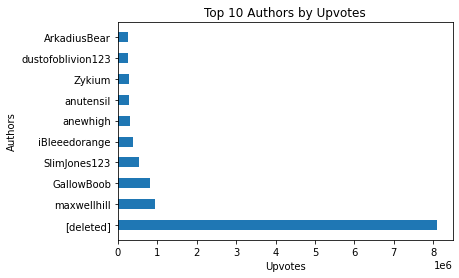

In [40]:
top_10 = ac.most_common(10)
authors, upvotes = [], []
for author, count in top_10:
    authors.append(author)
    upvotes.append(count)
plt.figure()
plt.barh(10*np.arange(len(authors)), upvotes, height=4.8)
plt.yticks(10*np.arange(len(authors)), authors)
plt.title('Top 10 Authors by Upvotes')
plt.xlabel('Upvotes')
plt.ylabel('Authors')
plt.show()